# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2022
## Домашнее задание 2. Методы нахождения оценок

Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook c:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде, 
* собственно кодом, 
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов, если не оговорено иного.

Загрузим все необходимые датасеты. Если что-то пошло не так, то просто скачайте файлы по ссылке вручную.

In [1]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1fMQ0H-_E4U25XHB2SH7ryoZPLG2MHlLQ
!gdown https://drive.google.com/uc?id=1cJywRii7wBZa0B2uAvvu56JFCLPnlOSs

Downloading...
From: https://drive.google.com/uc?id=1fMQ0H-_E4U25XHB2SH7ryoZPLG2MHlLQ
To: /content/Cauchy.csv
100% 18.7k/18.7k [00:00<00:00, 24.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cJywRii7wBZa0B2uAvvu56JFCLPnlOSs
To: /content/Weibull.csv
100% 17.9k/17.9k [00:00<00:00, 24.7MB/s]


In [2]:
import pandas as pd
import numpy as np
from scipy import stats as sps

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.4)

## Задача 1

На высоте 1 метр от поверхности Земли закреплено устройство,
которое периодически излучает лучи на поверхность Земли (считайте,
что поверхность Земли представляет из себя прямую). Пусть $l$ —
перпендикуляр к поверхности Земли, опущенный из точки, в которой
закреплено устройство. Угол к прямой $l$ (под которым происходит
излучение) устройство выбирает случайно из равномерного
распределения на от\-резке $\left(-\frac{\pi}{2}, \frac{\pi}{2}\right)$ (все выборы
осуществляются независимо). В этих предположениях точки пересечения
с поверхностью имеют распределение Коши с плотностью $p(x) =
\frac{1}{\pi(1 + (x-x_0)^2)}.$ Неизвестный параметр сдвига $x_0$
соответствует проекции точки расположения устройства на поверхность
Земли (направление оси и начало координат на поверхности Земли
выбраны заранее некоторым образом независимо от расположения
устройства). В файле Cauchy.csv находятся координаты точек
пересечения лучей с поверхностью Земли.

In [3]:
sample_1 = pd.read_csv("Cauchy.csv")["sample"].values


 Оцените параметр сдвига
методом максимального правдоподобия 
* по первым 10 измерениям
* по первым 100 измерениям
* по всей выборке. 

Оценку произведите по сетке (т.е. возьмите набор
точек с некоторым шагом и верните ту, на которой достигается
максимум функции правдоподобия). Известно, что параметр сдвига принадлежит интервалу $[-1000, 1000].$ Выберите шаг равным 0.01. Интервал можете итеративно уменьшать, но не стоит делать его длину меньше 50.


In [4]:
def ln_L(x, x0):
    return np.log(1 / (np.pi * (1 + (x - x0) ** 2)))

shifts = np.arange(-1000, 1000, 0.01)


def maximize(n = sample_1.size):
    best_estimator = shifts[0]
    max_value = np.sum(ln_L(sample_1[:n], shifts[0]))
    for shift in shifts:
        current_value = np.sum(ln_L(sample_1[:n], shift))
        if current_value > max_value:
            best_estimator = shift
            max_value = current_value
    return best_estimator



Сравните полученные результаты с `sps.cauchy.fit`

In [5]:
def sps_estimation(n = sample_1.size):
    return sps.cauchy.fit(sample_1)[:n][0]

sizes = np.array([10, 100, sample_1.size])

mle_arr = []
sps_arr = []
for sz in sizes:
    mle_arr.append(maximize(sz))
    sps_arr.append(sps_estimation(sz))
print("Оценки с помощью MLE:           ", mle_arr)
print("Оценки с помощью sps.cauchy.fit:", sps_arr)

Оценки с помощью MLE:            [208.52999999890085, 207.89999999890142, 207.97999999890135]
Оценки с помощью sps.cauchy.fit: [207.97772827944334, 207.97772827944334, 207.97772827944334]


**Вывод**: Оценка, полученная с помощью метода максимального правдоподобия, близка к истинной (даже при размере выборки 10 элементов). С ростом размера выборки оценка из ММП становится точнее. 

## Задача 2
В банкомате "Тинькофф" в Новом Корпусе МФТИ каждую минуту подсчитывается баланс по
сравнению с началом дня (6 часов утра). В полночь работники банка
измеряют две величины: $X^1$ – максимальное значение баланса за
день, $X^2$ – значение баланса в полночь. Считается, что величина
$X = X^1 - X^2$ имеет распределение Вейбулла с функцией распределения $F(x) = 1 - e^{-x^\gamma} (x > 0),$ где $\gamma > 0$ –
параметр формы. В течение 10 лет каждый день банк проводил
измерение величины $X,$ получив в результате выборку $X_1, \ldots,
X_{3652}.$ В файле Weibull.csv находятся соответствующие измерения.

In [6]:
sample_2 = np.loadtxt("Weibull.csv")
len(sample_2)

3652

Проведем небольшой предварительный анализ. Итак, если наши данные распределены согласно распределению Вейбулла, то справедливы следующие рассуждения:
$$
\begin{aligned} F(x) &=1-e^{-(x)^{\gamma}} \\-\ln (1-F(x)) &=x^{\gamma} \\ \underbrace{\ln (-\ln (1-F(x)))}_{y^{\prime}} &=\underbrace{\gamma \ln x}_{\text {kx }^{\prime}} \end{aligned}
$$
А значит и
$$
\underbrace{\ln (-\ln (1-\hat{F}(x)))}_{y^{\prime}} ≈\underbrace{\gamma \ln x}_{\text {kx }^{\prime}}
$$
Подсчитайте эмпирическую функцию распределения и 
$$y\prime = \ln (-\ln (1-\hat{F}(x))) \quad x' = ln x$$
 где $x$ – элементы исходной выборки. Постройте график (`plt.scatter`) выделив данные за первые четыре года красным цветом (`sample_2[:1461]`), остальные синим (`sample_2[1461:]`). Не забудьте про `alpha=0.05` и легенду. Такой график называется `Weibull plot` и является аналогом `qqplot` для распределения Вейбулла. 


Я прибавляю к нулевым элементам выборки маленький эпсилон, чтобы под логарифмом был не 0. А значения почти не поменяются.

In [7]:
from statsmodels.distributions.empirical_distribution import ECDF

eps = 0.0001

for i in range (0, len(sample_2)):
    if (sample_2[i] == 0):
        sample_2[i] += eps
        
sample_four_years = sample_2[:1461]
sample_others = sample_2[1461:]

ecdf = ECDF(sample_four_years)
x = np.log(sample_four_years)
y = np.log(-np.log(+eps + 1 - ecdf(sample_four_years)))

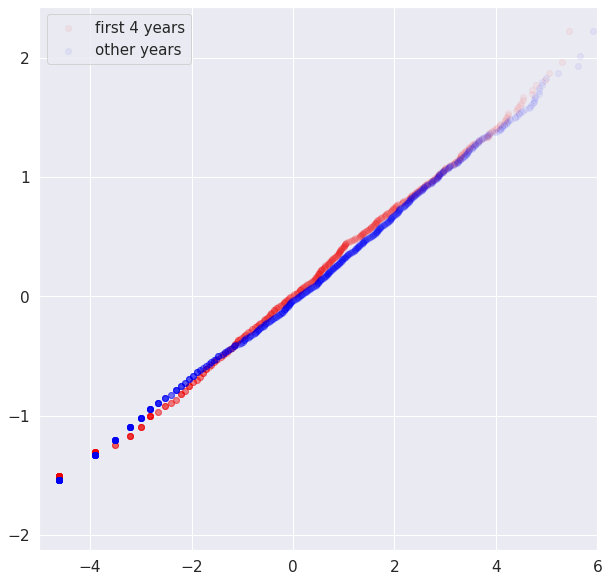

In [8]:
plt.figure(figsize=(10, 10))
plt.xlim(-5, 6)
plt.scatter(x,y, alpha=0.05, color='red', label="first 4 years")
plt.legend(fontsize=15)

ecdf = ECDF(sample_others)
x = np.log(sample_others)
y = np.log(-np.log(+eps + 1 - ecdf(sample_others)))

plt.scatter(x,y, alpha=0.05, color='blue', label="other years")
plt.legend(fontsize=15)

Сделайте вывод.

**Вывод**: Данные за первые 4 года и за оставшееся время очень похожи. Значения из выборки образуют прямую, проходящую через начало координат. Как и анонсировалось, выборка имеет распределение Вейбулла

Оцените параметр формы методом максимального правдоподобия 
* по
первым 4 годам; 
* по всей выборке.
Оценку произведите по сетке (в
логарифмической шкале). Известно, что $\log_{10}\gamma \in [-2, 2].$
Выберите шаг равным $10^{-3}.$

In [9]:
grid = np.arange(10**-2, 10**2, 0.001)

def count_est(sample):
    sample_resized = sample.reshape((sample.size, 1))
    likelihood_function = np.sum(np.log(sample_resized) * (grid - 1) + np.log(grid) - np.power(sample_resized, grid), axis=0)
    return grid[np.argmax(likelihood_function)]

estimations = np.array([count_est(sample_four_years), count_est(sample_2)])

print("Оценка параметра за 4 года: {0}".format(estimations[0]))
print("Оценка параметра по всей выборке: {0}".format(estimations[1]))

Оценка параметра за 4 года: 0.3509999999999997
Оценка параметра по всей выборке: 0.34499999999999975


Сравните результаты с `sps.weibull.fit(sample_2, fscale=1, floc=0)`

In [10]:
sps_est = np.array([(sps.weibull_min.fit(sample_four_years, fscale=1, floc=0)[0]), (sps.weibull_min.fit(sample_2, fscale=1, floc=0)[0])])
np.abs(estimations - sps_est)

array([1.2109375e-04, 1.9531250e-05])

Постройте график $y = \gamma \cdot x$ для всех полученных $\gamma$ (`plt.plot`) и `scatter plot` из предыдущего пункта ($y\prime \ x\prime$). Хорошо ли линии соответствуют выборке? Как вы думаете, почему?

**Вывод**

## Задача 3

Сгенерируйте выборки $X_1, \ldots, X_N$ из $\mathit{N}(0, \theta)$, $U(0, \theta)$, $\Gamma(1, \theta)$ (**параметризация $k, \theta$**), $\theta = 3$ для всех распределений $(N = 1000).$ Для всех $n \leq N$ посчитайте значения оценок (по выборке $X_1, \ldots X_n$) методом моментов. Постройте график ошибки оценки от реального значения ($|\hat\theta - \theta|_{l_1}$) относительно размера выборки.

Найдем методом моментов оценку $\hat{\theta}$ для $\theta$:

Нормальное распределение:

$\mathbb{E} x = 0$

$\mathbb{E}x^2 = \theta - \mathbb{E}x = \theta$

$\hat{\theta} = \overline{x^2}$

Равномерное распределение:

$\mathbb{E}x = \frac{\theta}{2}$

$\hat{\theta} = 2 \overline{x}$

Гамма распределение:

$\mathbb{E}x = \theta$

$\hat{\theta} = \overline{x}$

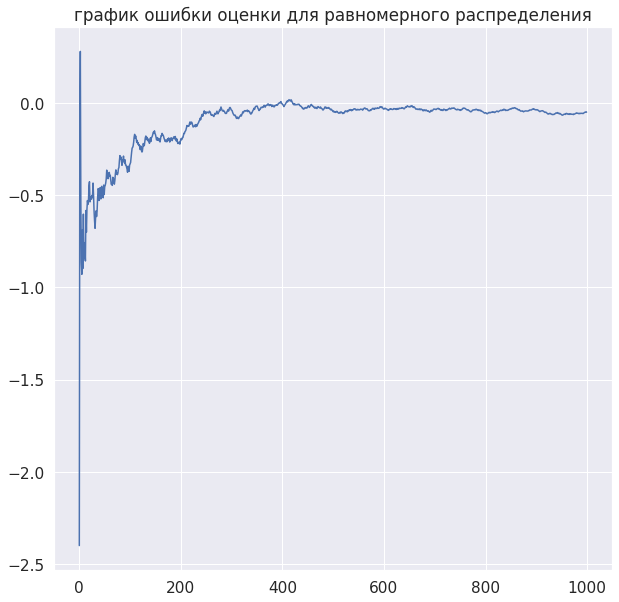

In [11]:
theta = 3
N = 1000
sample_norm = np.random.normal(loc=0, scale=np.sqrt(theta), size=N)

sample_uniform = np.random.uniform(0, theta, N)

sample_gamma = np.random.gamma(1, theta, N)

plt.figure(figsize=(10, 10))

sum_x_i_uniform = np.cumsum(sample_uniform)
for n in range(1, N):
    sum_x_i_uniform[n] *= 2/n
plt.title("график ошибки оценки для равномерного распределения")
plt.plot(sum_x_i_uniform - theta)



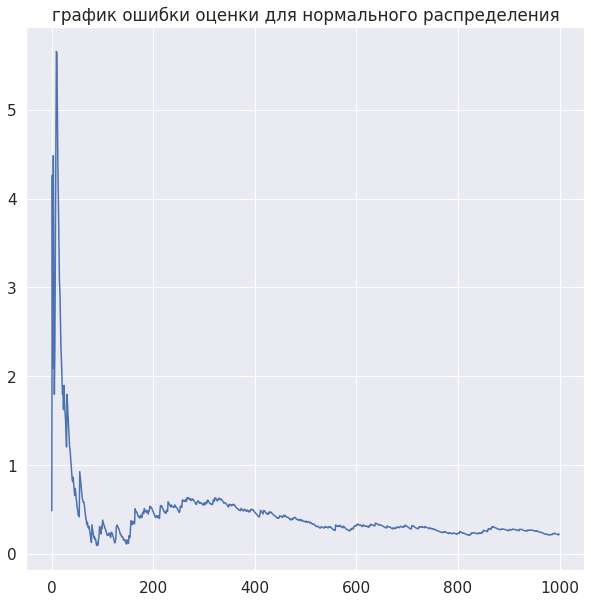

In [12]:
plt.figure(figsize=(10, 10))
sum_x_i_normal = np.cumsum(sample_norm**2)
for n in range(1, N):
    sum_x_i_normal[n] *= 1/n
plt.title("график ошибки оценки для нормального распределения")
plt.plot(sum_x_i_normal - theta)

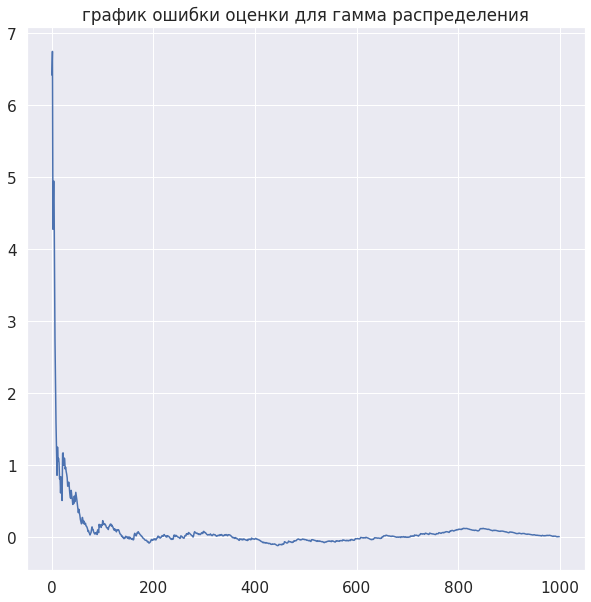

In [13]:
plt.figure(figsize=(10, 10))
sum_x_i_gamma = np.cumsum(sample_gamma)
for n in range(1, N):
    sum_x_i_gamma[n] *= 1/n
plt.title("график ошибки оценки для гамма распределения")
plt.plot(sum_x_i_gamma - theta)


**Вывод**: С ростом размера выборки ошибки оценка стремится к реальному значению

### Бутстреп

Для реальных данных часто сложно подобрать распределение и нужную параметризацию относительно $\theta$. Кроме того на практике сложно посчитать дисперсию оценки (для этого хотя бы нужно знать распределение, из которого пришла выборка). На помощь в таких случаях приходит **бутстреп**.

Идея очень простая. Давайте возьмем нашу выборку размера $N$ и сгенерируем из нее еще $K$ выборок. Более формально для каждой бутстрепной выборки N раз будем выбирать элементы из исходной выборки с возвращением. Полученная таким образом выборка будет содержать $\approx 63$% уникальных элементов, но это не страшно. Для всех $K$ выборок посчитаем оценку $\hat\theta$. Таким образом мы получим $K$ оценок параметра. Можно показать, что если размер бутстрепных выборок и исходной совпадают, то оценка дисперсии $s^2(\hat\theta)$, полученная из $K$ оценок, будет *хорошей*.

Для каждого распределения из предыдущего пункта (Пожалуйста, не пишите цикл по распределениям. Сделайте три отдельные ячейки) для каждого $K$ из `[10] + [50] + list(range(100, 1001, 100))` сгенерируйте K бутстрепных выборок и посчитайте дисперсию бутстрепных оценок и посчитайте среднее по K выборкам. Размер бутстрепной выборки сделайте равным $K$, не забудьте уменьшить размер исходной выборки до $K$. Постройте график следующим образом: по оси $x$ отложите значения $K$, красной линией обозначьте среднее значение $\hat\theta$ бутстрепных выборок для каждого $K$. Посчитайте стандартное отклонение оценки для каждого $K$ и закрасьте интервал $\mu(k) \pm \sigma(\hat\theta)$ (`plt.fillbetween`).

